In [1]:
from models.regressionnet_resnet import *
from scripts import tools
from scripts import dataset
from scripts.config import *
import cv2

def normalize_img(img):
    tmp_shape = img.shape
    img = img.astype(np.float32)
    img -= img.reshape(-1, 3).mean(axis=0)
    img /= img.reshape(-1, 3).std(axis=0) + 1e-5
    img = img.reshape(tmp_shape)
    return(img)

tools.etc.set_GPU("0")

In [2]:
net = Regressionnet(data_shape=(128,128,3),num_joints=14,gpu_memory_fraction=None, phase='inference')  

with net.graph.as_default():
    saver = tf.train.Saver()
    saver.restore(net.sess, "./out/gpu3/Regressionnet_highest_pcp.ckpt")
    
    test_it = dataset.met("./dataset/MET7/met7_test.csv", Bbox=True, Bbox_mode='apply', scale_set=[1.5],
                          re_img_size=(128,128), dataset_root="./dataset/MET7/", Shuffle=False, normalize=True)
    
orig_img_set = dataset.met("./dataset/MET7/met7_test.csv", Bbox=True, Bbox_mode='apply', scale_set=[1.5],
                           re_img_size=(128,128), dataset_root="./dataset/MET7/", Shuffle=False, normalize=False).img_set

INFO:tensorflow:Restoring parameters from ./out/gpu3/Regressionnet_highest_pcp.ckpt


[ {{BBOX}} Applying Images & Coordinates]: 100%|██████████| 174/174 [00:00<00:00, 3823.05it/s]


In [3]:
predicted_joints = net.sess.run(
    [net.fc_regression],
    feed_dict={net.x : test_it.img_set, net.keep_prob:1.0, net.is_train: False})[0]

predicted_joints = predicted_joints.reshape(len(predicted_joints),14,2)
pred_canonical = tools.pose.convert2canonical(predicted_joints)
orig_canonical = tools.pose.convert2canonical(test_it.coor_set.reshape(-1,14,2))

In [4]:
tools.analysis.get_pcp_stick_result_table_per_activities(test_it.labels, orig_canonical, pred_canonical)

,Sleeping,Reclining,Seated.quiet,Standing.Relaxed,Reading.seated,Writing,Typing,Filing.Seated,Filing.Stand,Walking about,Average
Head,0.81,0.88,0.82,0.82,0.82,0.76,0.94,0.88,0.53,0.76,0.80
Torso,0.90,0.94,0.88,1.00,0.94,0.88,0.94,0.88,0.88,0.94,0.92
U Arm,0.74,0.74,0.82,0.94,0.82,0.74,0.94,0.88,0.62,0.85,0.81
L Arm,0.64,0.68,0.76,0.85,0.79,0.71,0.85,0.88,0.65,0.85,0.76
U Leg,0.86,0.82,0.85,0.94,0.88,0.74,0.94,0.88,0.71,0.94,0.86
L Leg,0.83,0.97,0.91,0.97,0.91,0.79,0.94,0.85,0.65,0.91,0.87
Mean,0.80,0.84,0.84,0.92,0.86,0.77,0.93,0.88,0.67,0.88,0.84


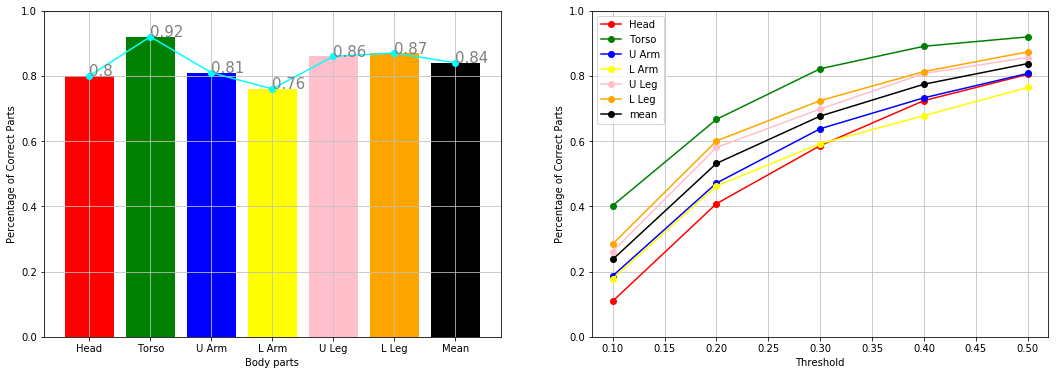

In [5]:
tools.analysis.show_pcp_result_plot_per_sticks(test_it.labels, orig_canonical, pred_canonical)

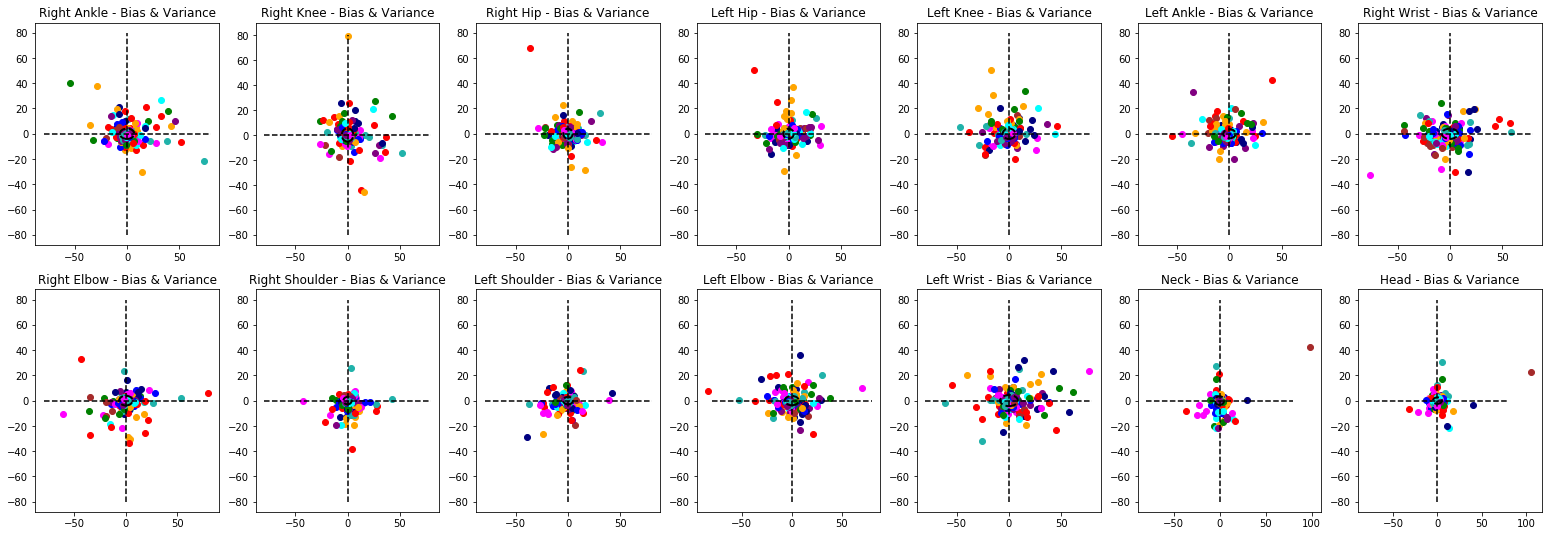

In [6]:
tools.analysis.visualize_Variances_per_joint(test_it.labels, test_it.coor_set, predicted_joints)

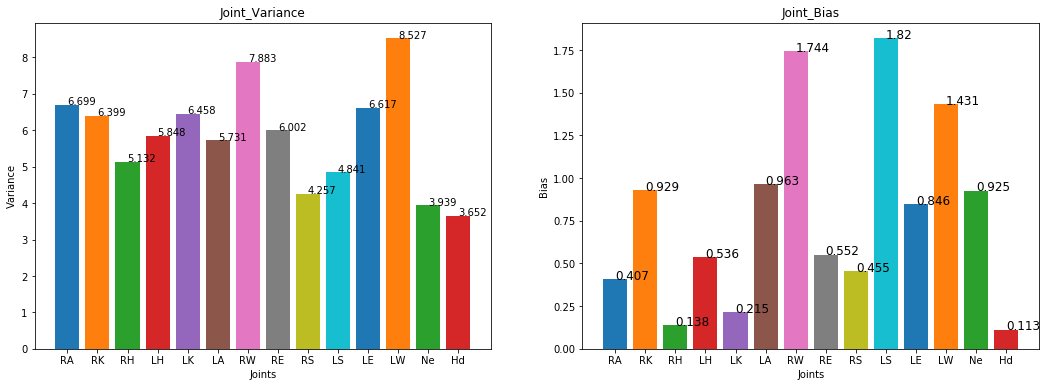

In [7]:
tools.analysis.hist_Variance_Bias_per_joint(test_it.coor_set, predicted_joints)

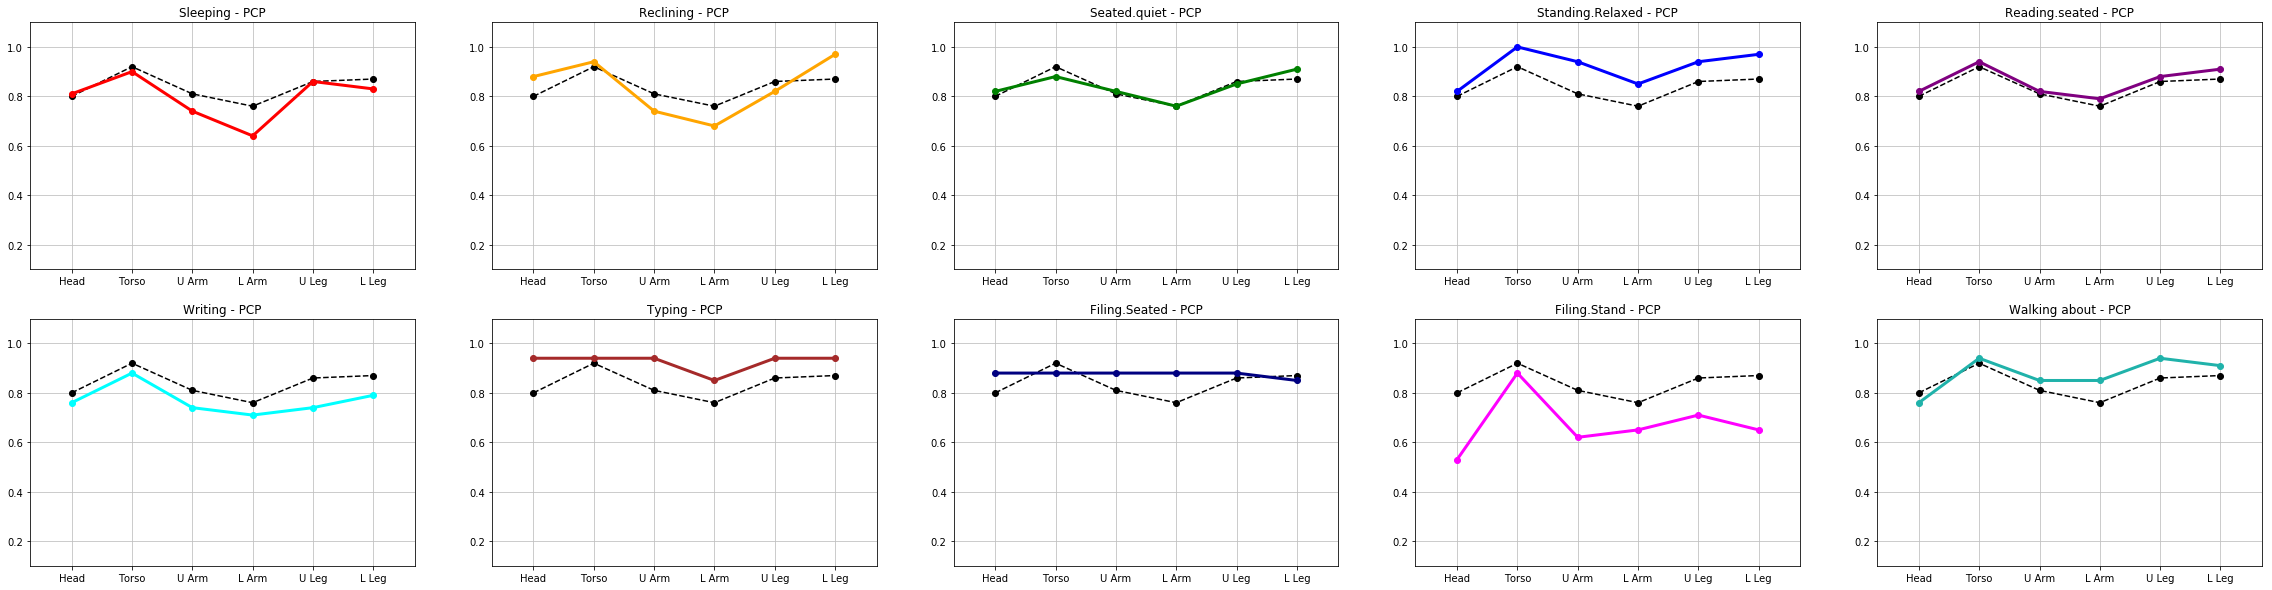

In [8]:
tools.analysis.plot_total_pcp_result(test_it.labels, orig_canonical, pred_canonical)

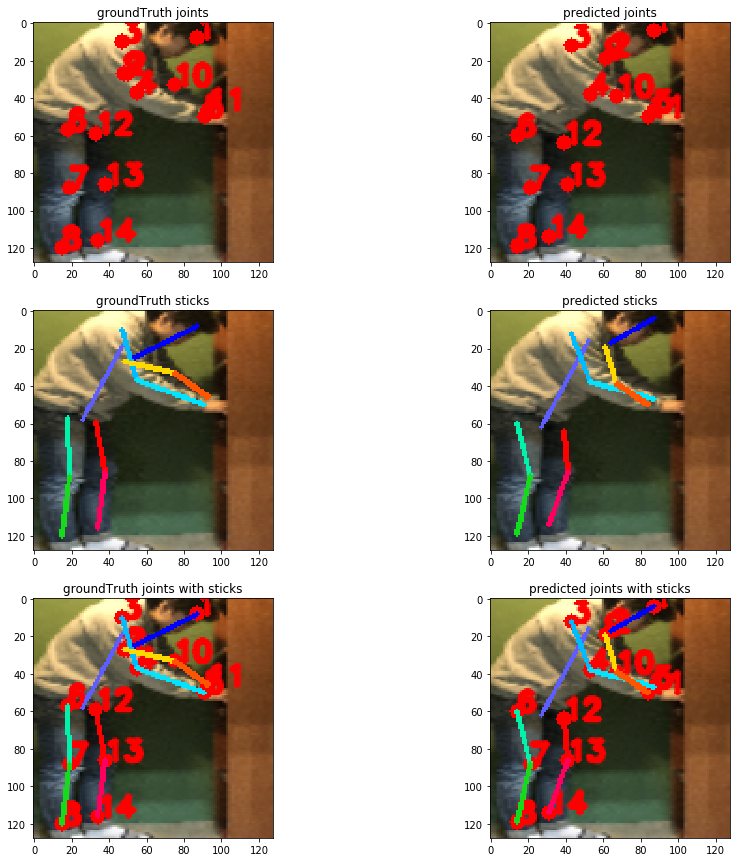

In [9]:
idx=173

tools.analysis.demo_plot(orig_img_set[idx], orig_canonical[idx], pred_canonical[idx])

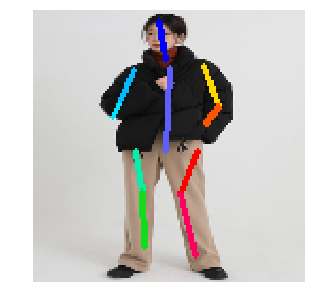

In [10]:
plt.rcParams["figure.figsize"] = (5,5)
test_img = cv2.resize(cv2.imread('/home/hahnz/test/th.png')[:,300:],(128,128))
norm_img = normalize_img(test_img)
pred_joints = net.sess.run(net.fc_regression, {net.x : [norm_img], net.is_train:False})
pred_sticks =  tools.pose.convert2canonical(pred_joints.reshape(1,-1,2))[0]['sticks']
pred_img = tools.etc.drawSticks(test_img, pred_sticks)
#pred_img = tools.etc.markJoints(pred_img, pred_joints.reshape(-1,2))
plt.imshow(pred_img[:,:,[2,1,0]])
plt.axis('off')
plt.show()